In [ ]:
#  Deep Learning
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning
from sklearn.model_selection import train_test_split

# other libreries 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## ***CONTENT BASED IMAGE RETRIEVAL***

In this notebook we want to design a _content based image retrieval_ for mammography images. Especially, given an image of a patient, we desire to **retrieve the best set of images** from our database. In a realistic situation, images of database are attached to a medical record of the previous patients and then the radiologist, can compare the new case with the retrieved sets. This is a **computer-aided detection**(**CADe**) with the aim to support the radiologist on the diagnostic choice. 

We implement the following pipeline:
- Import focused images of a breast with a benign or malignant cancer. Focused image refers to the fact that we make a zoom to the original one in order to focus on the critical region: this is the **database**. 

Moreover, we choose three different images as query: a benign, malign and flat one. Where the first one shows a benign cancer, the second one a malignant cancer and the third one represents a malignant cancer with a low evidence (flat region). 
- Import the _VVG16 net with imagenet weights_. Preprocess all the images (database and query) for the network.
- Cut the net at **block4_pool** layer. We previously selected the *block3_pool* but due to the large number of provided features the RAM saturated. So, we decided to take *block4_pool* because it's enough closer to the input meaning that it can catch low-level fetures, the ones in which we are interested in. 
- **Predict** both the dataset and query images in order to replace each image with a vector of features.
- Compute the **euclidean distance** between the queries and the image of database. 

In order to evaluate the performance, we rely on **human evaluation**. When the query is the malignant one (this is the a new patient and the type of cancer is unknown but we assume to know it in order to evaluate the model), the retrieved images show nuggets of tissue that have an irregular shape, while the retirived of benign ones are more smooth. Maybe, the shape is an important factor to undestand the dangerous of cancer. Moreover, the images retrieved for the flat region don't contain nuggets, so the system is able to distinguish between this case and the others. 

In order to build a more complete CADe, we should analyse the diagnosis that patients receveid in the past and their effectiveness. At this stage, we can perform this system that is the initial point of a more accurate and professional CADe.

### **Import data**

In [ ]:
path = './gdrive/MyDrive/DSIM/Focus/'

# creazione del dataset 
x = []
y = []

cnt=0
for dir0 in os.listdir(path):  
  print(dir0,"\n\n") ## MalignFocus / BeningFocus
  if dir0=='MalignFocus':
    classes=0
  else:
     classes=1
  print(classes)
  
  for dir1 in os.listdir(path+dir0):
    print(path+dir0+"/"+dir1,"\n") ## CC/MLO

    for dir2 in os.listdir(path+dir0+"/"+dir1):
        img = image.load_img(path+dir0+"/"+dir1+"/"+dir2, target_size=(224, 224))
        img = image.img_to_array(img)
        x.append(img)
        y.append(classes)
        cnt+=1
    
    print(cnt)

  #cambio valore il maligno è 0 il benigno è 1

  
  # maligno classes = 0 | benigno classes = 1

MalignFocus 


0
./gdrive/MyDrive/DSIM/Focus/MalignFocus/MLO 

640
./gdrive/MyDrive/DSIM/Focus/MalignFocus/CC 

1255
BenignFocus 


1
./gdrive/MyDrive/DSIM/Focus/BenignFocus/MLO 

1898
./gdrive/MyDrive/DSIM/Focus/BenignFocus/CC 

2528


### **Pre-processing**

In [ ]:
# convert to np.array
x = np.array(x)
# preprocess the input in order to 
# work with chosen net.
x = preprocess_input(x)

### **Feature extraction**

In [ ]:
#  Download of the Network without Fully connected layers.
base_model = VGG16( weights = 'imagenet', 
                   include_top = False)

## Extract features from block 4.
first_model_pool = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
block_pool = first_model_pool.predict(x)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
print(block_pool.shape)

(2528, 14, 14, 512)


In [ ]:
# Flatten images and check dimensionality.
block_pool_flatten = np.array([img.flatten() for img in block_pool])
print(block_pool_flatten.shape)

(2528, 100352)


### **Image Retrieval**

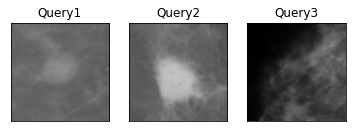

In [ ]:
# Path of queris.
path_benign = './gdrive/MyDrive/QueryFocus/Benign/CC/Focus4090.png'
path_malign = './gdrive/MyDrive/QueryFocus/Malign/CC/Focus4178.png'
path_flat = './gdrive/MyDrive/QueryFocus/Malign/CC/Focus4199.png' 

query_benign = image.load_img(path_benign,target_size=(224,224))
query_malign = image.load_img(path_malign,target_size=(224,224))
query_flat = image.load_img(path_flat,target_size=(224,224))


list_im = [query_benign, query_malign, query_flat]

for i in range(0,3):
  plt.subplot(1,3,i+1)
  plt.imshow(list_im[i],cmap='gray')
  plt.title("Query" +str(i+1))
  plt.xticks([])
  plt.yticks([]) 


In [ ]:
# Extract features for query images 
# in order to compute the similarity 
# between train data.

def preparation(img):
  img = image.img_to_array(img)
  x = np.array(img)
  x = preprocess_input(x)
  x = np.expand_dims(x,axis=0)
  pred = first_model_pool.predict(x)
  pred = pred.flatten()
  pred = np.expand_dims(pred,axis=0)
  return pred

query_benign = preparation(query_benign)
query_malign = preparation(query_malign)
query_flat = preparation(query_flat)

In [ ]:
# Compute the difference between query and data 
# with KDTree.
# We use euclidean distance.

# Number of retrived images.
k = 3

from sklearn.neighbors import KDTree

tree = KDTree(block_pool_flatten)

dist_1, ind_1 = tree.query(query_malign, k = k) 
print(dist_1)

dist_2, ind_2 = tree.query(query_benign, k = k) 
print(dist_2)

dist_3, ind_3 = tree.query(query_flat, k = k) 
print(dist_3)

[[8017.84325214 8056.75278382 8172.22737666]]
[[5316.68563057 5403.63282144 5420.98642068]]
[[12311.76295069 12464.9063708  12531.23538397]]


RETRIEVED OF THE FIRST QUERY


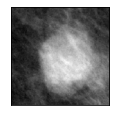

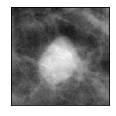

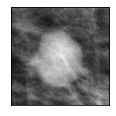

In [ ]:
# Retrived of the first query (benign)

print('RETRIEVED OF THE FIRST QUERY')
for i in range(0,3):
  plt.subplot(1,3,i+1)
  plt.imshow(x[ind_1[0,i],:,:,0],cmap='gray')
  plt.xticks([])
  plt.yticks([]) 
  plt.show()
  

RETRIEVED OF THE SECOND QUERY


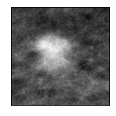

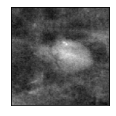

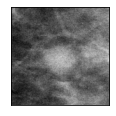

In [ ]:
# Retrived of the first query (malign)

print('RETRIEVED OF THE SECOND QUERY')
for i in range(0,3):
  plt.subplot(1,3,i+1)
  plt.imshow(x[ind_2[0,i],:,:,0],cmap='gray')
  plt.xticks([])
  plt.yticks([]) 
  plt.show()
  

RETRIEVED OF THE THIRD QUERY


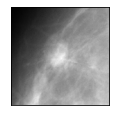

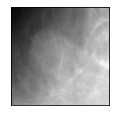

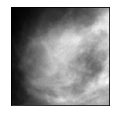

In [ ]:
# Retrived of the first query (flat)

print('RETRIEVED OF THE THIRD QUERY')
for i in range(0,3):
  plt.subplot(1,3,i+1)
  plt.imshow(x[ind_3[0,i],:,:,0],cmap='gray')
  plt.xticks([])
  plt.yticks([]) 
  plt.show()
  